System setup

In [2]:
%matplotlib inline

import random
import itertools
import matplotlib.pyplot as plt
import pymc3             as pm
import numpy             as np

from scipy                   import stats
from functools               import partial
from IPython.core.pylabtools import figsize

# Probabilistic Programming for Data Mining

(am Beispiel A/B Testing)

### Probabilistic Programming

vgl. http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC3.ipynb und https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd

* Modellkomponenten, d. h. Zufallsvariablen und Verteilungen, können direkt als (stochastische) Variablen modeliert werden.

* Es stehen Sampling-Methoden zur Verfügung, die erheblich performanter arbeiten als der ABC-Ansatz (höhere Akzeptanzrate): Markov Chain Monte Carlo (Metropolis Hastings and Gibbs Sampling), Hamiltonian Monte Carlo und ADVI. 

Daten:

In [3]:
observations_A = stats.bernoulli.rvs(0.04, size=1500)
observations_B = stats.bernoulli.rvs(0.05, size=750)

In [4]:
with pm.Model() as model:
    
    # Definiere a-priori Verteilungen.
    prior_A = pm.Uniform("prior_A", 0, 1)
    prior_B = pm.Uniform("prior_B", 0, 1)
    
    # Definiere die Verteilung der Beobachtungen.
    obs_A = pm.Bernoulli("obs_A", prior_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", prior_B, observed=observations_B)
    
    # Definiere die notwendigen Evaluierungsmetriken.
    delta = pm.Deterministic("delta", prior_A - prior_B)

    # Bayes'sche Inferenz.
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)
    burned_trace=trace[1000:]

Optimization terminated successfully.
         Current function value: 442.248864
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17


100%|██████████| 50500/50500 [00:20<00:00, 2485.21it/s]


Nun können wir bereits das Ergebnis evaluieren: Zunächst schauen wir uns an, wie stark unsere Überzeugung ist, dass Layout B besser ist als Layout A:

In [5]:
p_A_samples = burned_trace["prior_A"]
p_B_samples = burned_trace["prior_B"]
delta_samples = burned_trace["delta"]

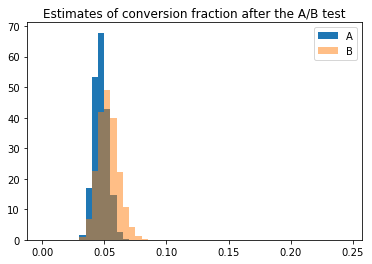

In [6]:
abbins = [i/200.0 for i in range(50)]  # 50 bins between 0 and 0.25
plt.hist(p_A_samples, bins=abbins, label='A', normed=True)
plt.hist(p_B_samples, bins=abbins, label='B', alpha=0.5, normed=True)
plt.title('Estimates of conversion fraction after the A/B test')
plt.legend();

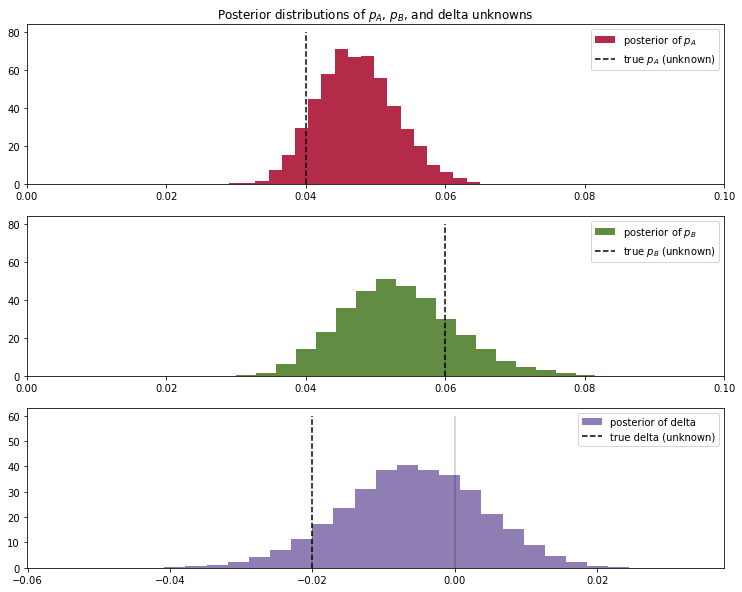

In [7]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", normed=True)
plt.vlines(0.04, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", normed=True)
plt.vlines(0.06, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(0.04 - 0.06, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");

Alternativ kann man die Ausgabe auch über eine in-built Funktion steuern:

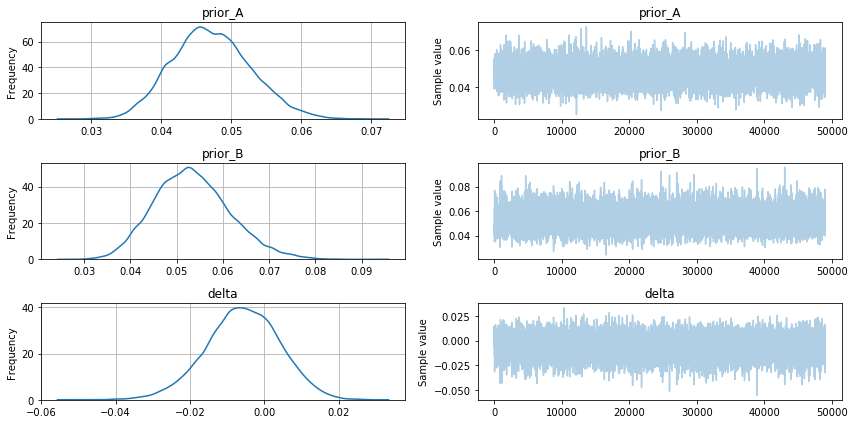

In [8]:
_ = pm.traceplot(trace[1000:], grid=True)

Man erkennt, dass die Masse der Deltas kleiner ist als 0.Das deutet darauf hin, dass Layout B besser ist als Layout A.

Um genauer zu spezifizieren, wie sicher wir uns sind, dass Layout B besser ist als Layout A, berechnen wir die dazugehörige Wahrscheinlichkeit:

In [9]:
print("Wahrscheinlichkeit, dass Layout B BESSER ist als Layout A: %.3f" % \
    np.mean(delta_samples < 0))

print("Wahrscheinlichkeit, dass Layout B SCHLECHTER ist als Layout A: %.3f" % \
    np.mean(delta_samples > 0))

Wahrscheinlichkeit, dass Layout B BESSER ist als Layout A: 0.724
Wahrscheinlichkeit, dass Layout B SCHLECHTER ist als Layout A: 0.276


Auch diese 'Konfidenz' können wir uns mit eine in-built Funktion anzeigen lassen:

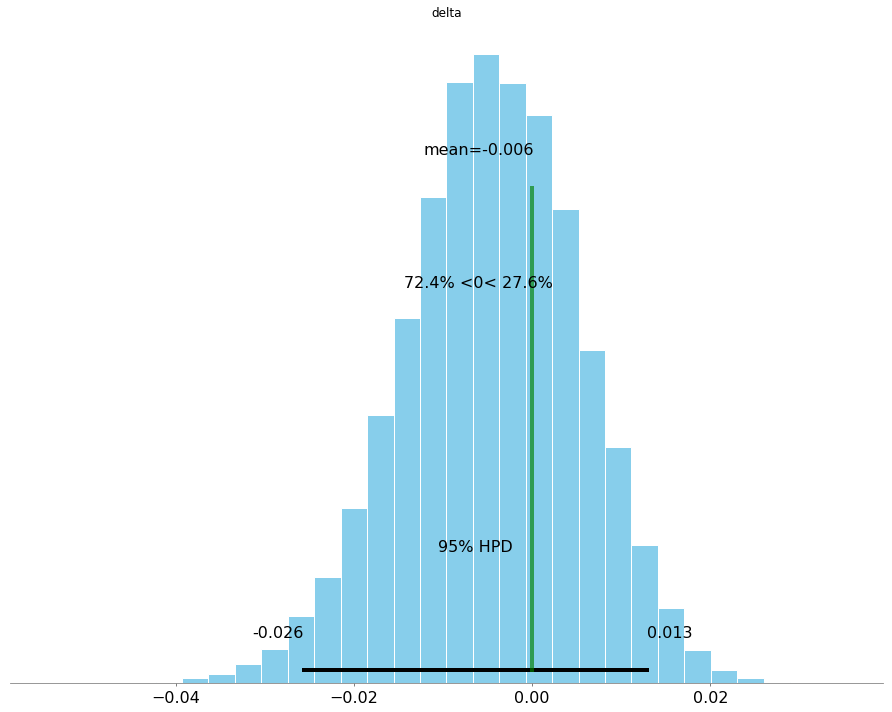

In [10]:
_ = pm.plot_posterior(trace[1000:], varnames=['delta'], 
                      ref_val=0, color='#87ceeb')

Anhand dieser Werte kann nun entschieden werden, ob wir ausreichend sicher sind, um eine Entscheidung zu treffen.